# Feature Engineering

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# 1.1 Load Data

In [18]:
train = pd.read_csv("train.csv")
val = pd.read_csv("val.csv")

explore = pd.concat([train, val], axis=0)

explore.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4468400169,1,18,0,0,3,4,4,1,1,...,0,15644,7.0,17861,246,51,987,555,24.6,1564.4
1,4462377853,0,123,2,1,6,6,6,0,0,...,0,15950,7.0,18377,216,49,-428,558,21.6,1595.0
2,4461787791,1,89,3,1,7,5,7,1,1,...,0,15586,7.0,17668,193,60,-1902,-967,19.3,1558.6
3,4497751825,0,17,3,1,7,10,5,0,0,...,0,18178,6.4,16533,181,52,2827,2675,18.1,1817.8
4,4521575223,1,146,1,0,11,7,9,0,0,...,0,17956,6.8,18421,226,73,-564,-633,22.6,1795.6


# 2.1 Making New Columns

In [19]:
def create_feats(dataset):
    cols_to_be_dropped = []

    for col1 in dataset.columns:
        if col1.startswith("blue"):
            for col2 in dataset.columns:
                if col2 == "red" + col1[4:]:
                    dataset["ratio" + col1[4:]] = dataset[col1] / (dataset[col2] + 1)
                    dataset["difference" + col1[4:]] = dataset[col1] - dataset[col2]
                    cols_to_be_dropped.append(col1)
                    cols_to_be_dropped.append(col2)
                
    for col in cols_to_be_dropped:
        dataset.drop(col, axis=1, inplace=True)
        
    return dataset
        
explore = create_feats(explore)

# 3.1 Selecting Features: Looking At Correlation To Target

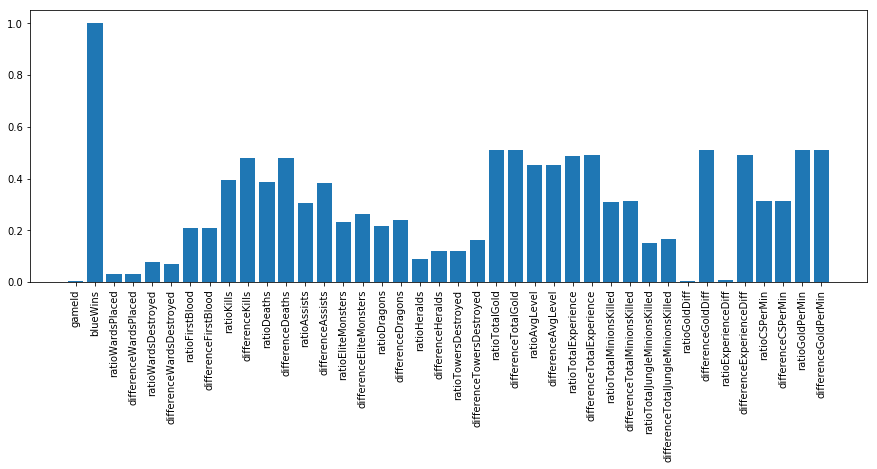

In [20]:
plt.figure(figsize=(15, 5))
plt.bar(explore.columns, abs(explore.corr()["blueWins"]))
plt.xticks(rotation=90)
plt.show()

In [21]:
# save the most correlated features
cols_with_corrs = zip(explore.columns, abs(explore.corr()["blueWins"].values))

high_corr_columns = pd.DataFrame([])
                      
for col, corr in cols_with_corrs:
    if corr >= 0.2:
        high_corr_columns[col] = explore[col]
                                      
high_corr_columns.columns

Index(['blueWins', 'ratioFirstBlood', 'differenceFirstBlood', 'ratioKills',
       'differenceKills', 'ratioDeaths', 'differenceDeaths', 'ratioAssists',
       'differenceAssists', 'ratioEliteMonsters', 'differenceEliteMonsters',
       'ratioDragons', 'differenceDragons', 'ratioTotalGold',
       'differenceTotalGold', 'ratioAvgLevel', 'differenceAvgLevel',
       'ratioTotalExperience', 'differenceTotalExperience',
       'ratioTotalMinionsKilled', 'differenceTotalMinionsKilled',
       'differenceGoldDiff', 'differenceExperienceDiff', 'ratioCSPerMin',
       'differenceCSPerMin', 'ratioGoldPerMin', 'differenceGoldPerMin'],
      dtype='object')

# 3.2 Selecting Features: Chi Squared Test

In [22]:
scaler = MinMaxScaler()
normalized = scaler.fit_transform(high_corr_columns)
results = chi2(normalized, explore["blueWins"])[1]
results

array([0.00000000e+00, 8.77964079e-36, 8.77964079e-36, 4.90541194e-16,
       1.89244991e-13, 2.18135997e-14, 2.47516502e-14, 5.99090750e-16,
       3.11844783e-08, 2.80053960e-34, 5.52960941e-18, 3.15999570e-50,
       1.07250156e-39, 1.80332053e-14, 2.58267975e-12, 6.72740440e-07,
       1.81716785e-07, 2.00086363e-09, 2.14238899e-10, 4.70780440e-05,
       9.05611347e-07, 2.58267975e-12, 2.14238899e-10, 4.61095495e-05,
       9.05611347e-07, 1.80796911e-14, 2.58267975e-12])

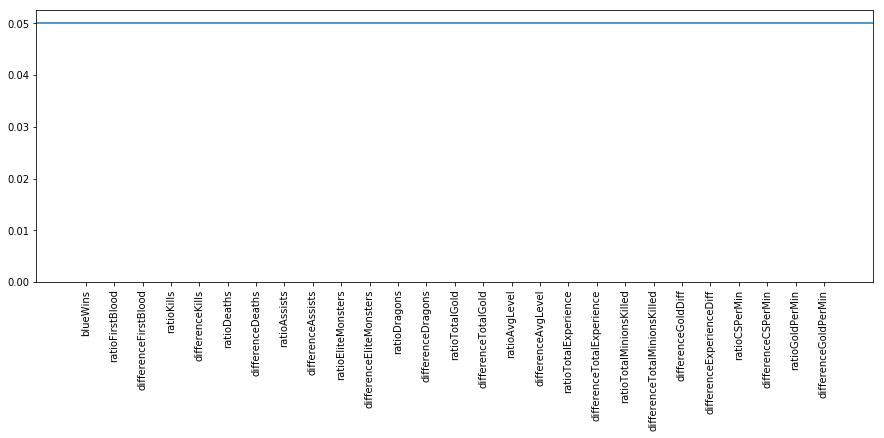

In [23]:
plt.figure(figsize=(15, 5))
plt.bar(high_corr_columns.columns, results)
plt.axhline(0.05)
plt.xticks(rotation=90)
plt.show()

# 3.3 Select Features: MultiColinearity

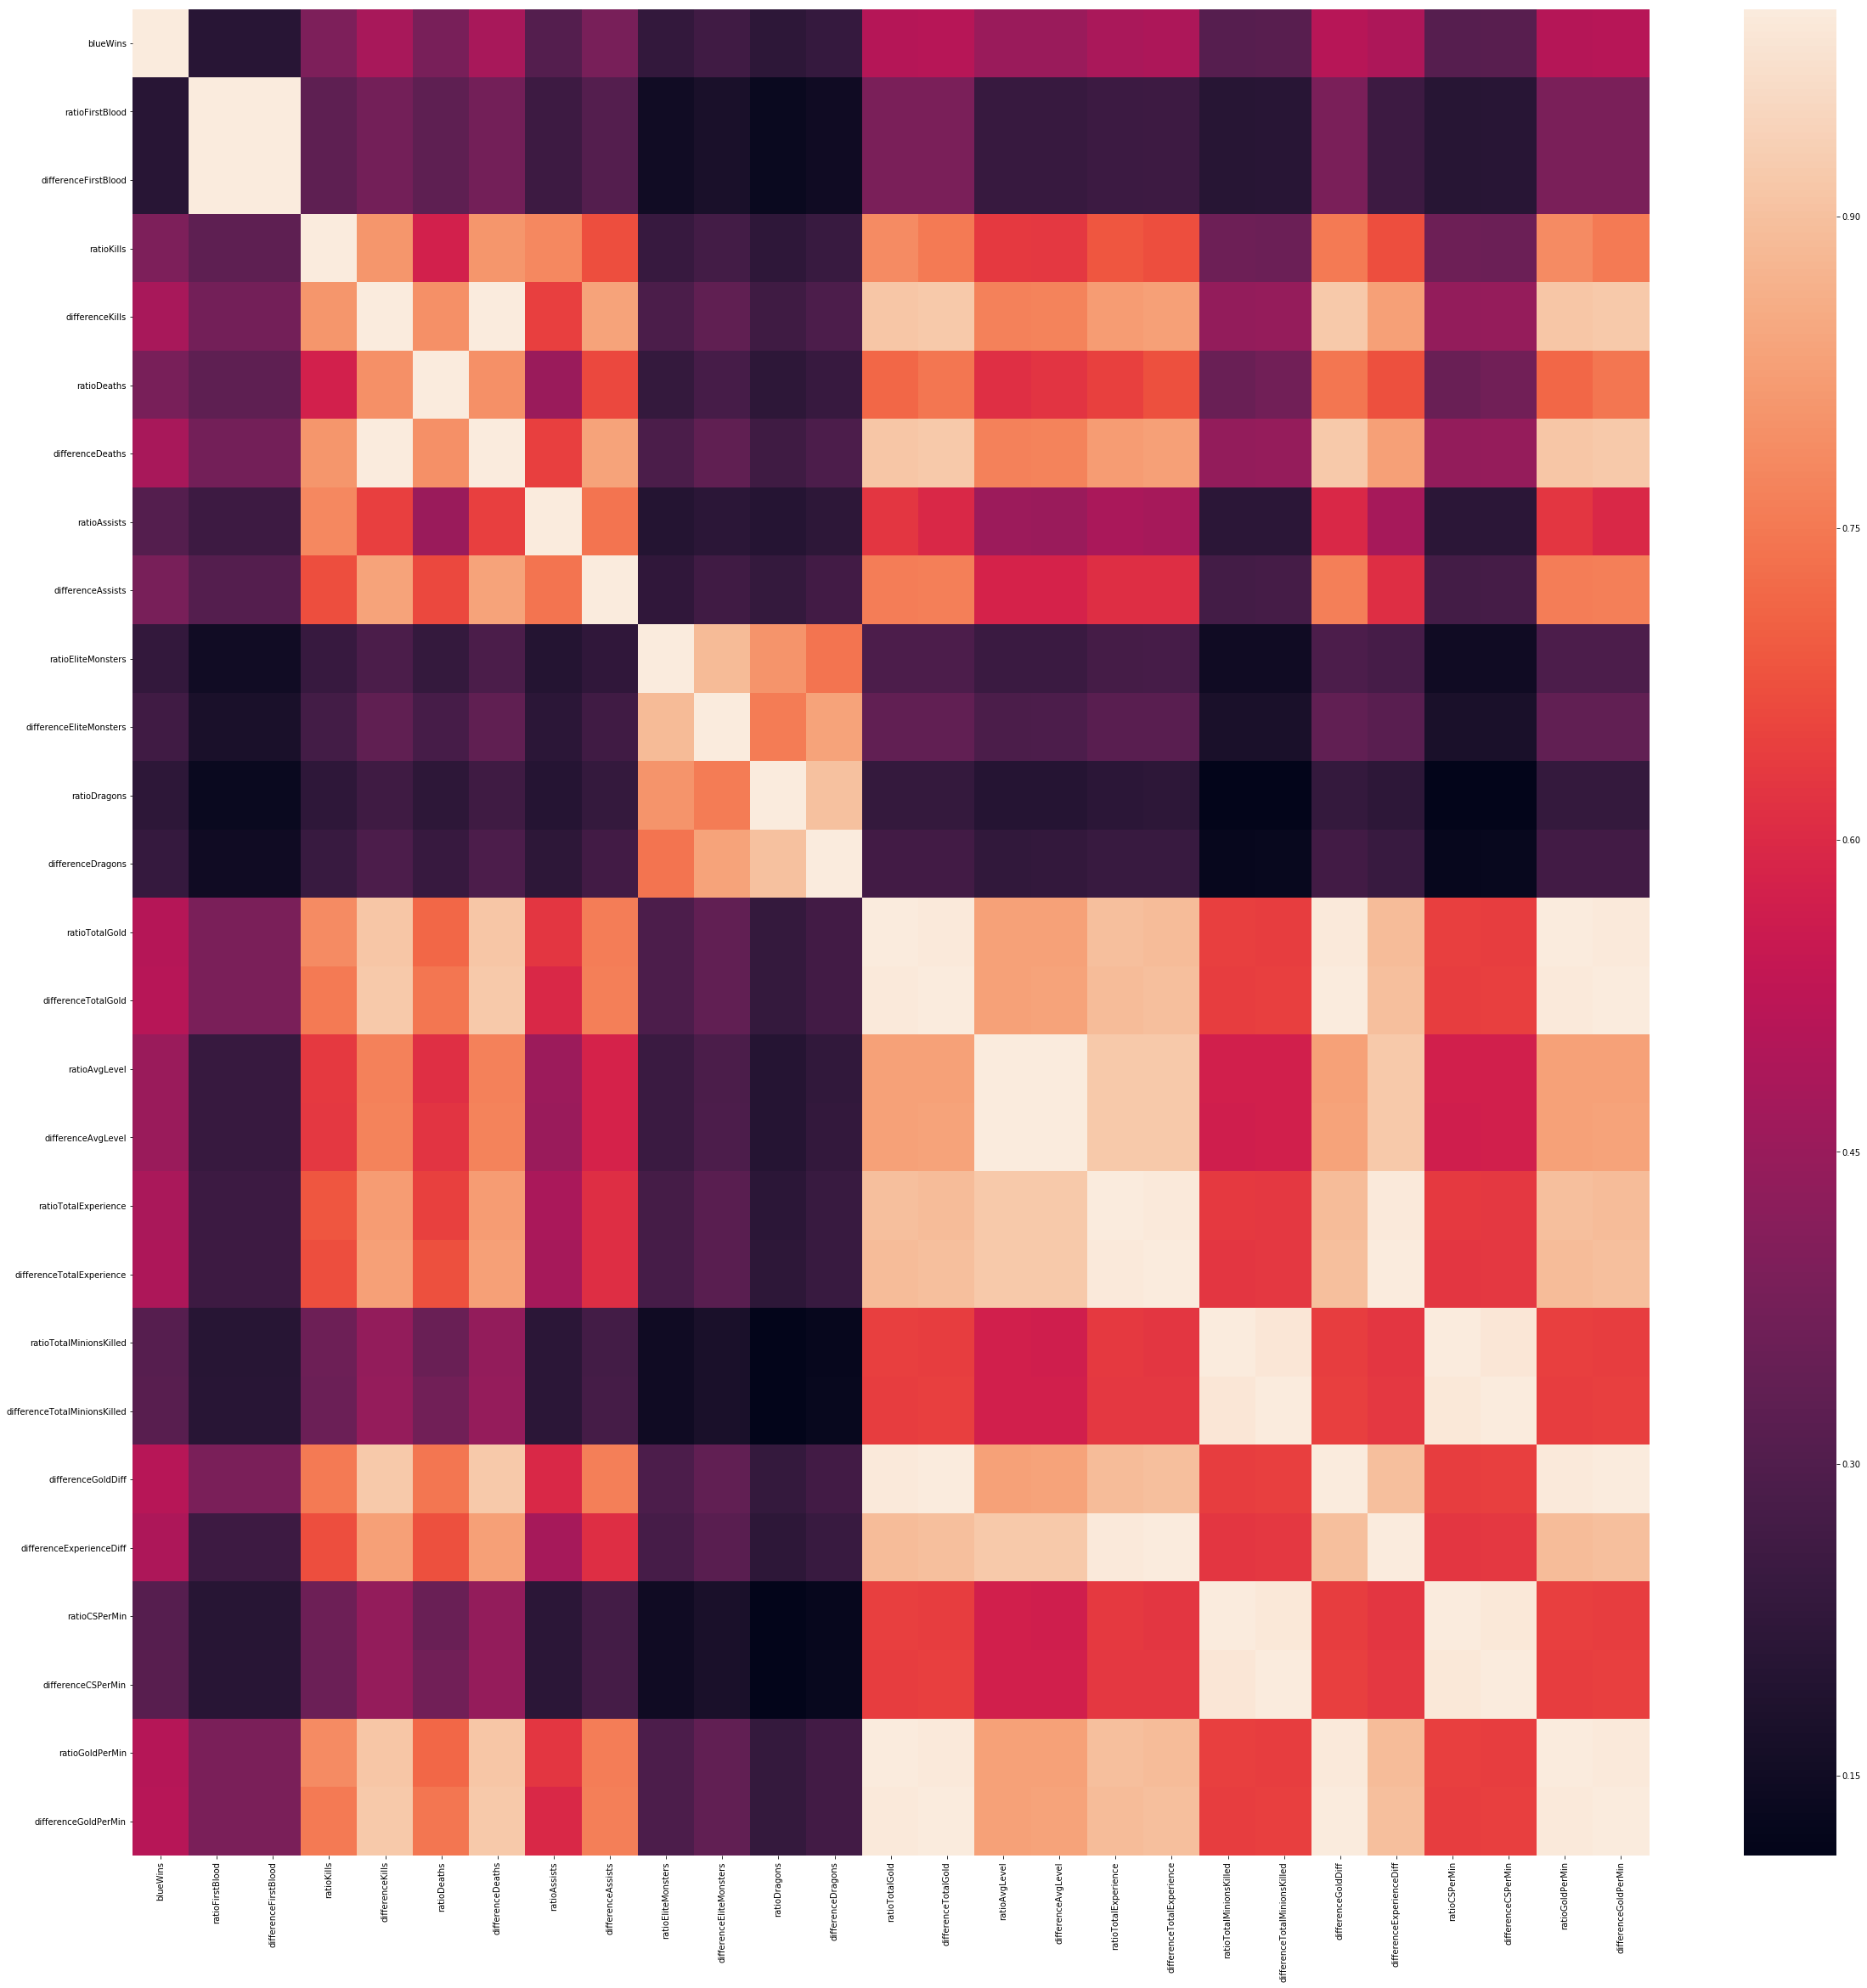

In [24]:
plt.figure(figsize=(40, 40))
sns.heatmap(abs(high_corr_columns.corr()))
plt.show()

# 4.1 PCA

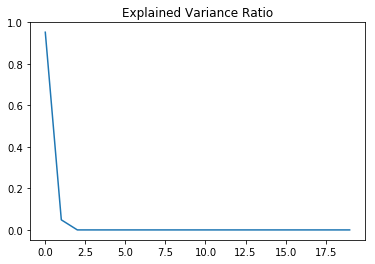

In [25]:
X = high_corr_columns.drop("blueWins", axis=1)
pca = PCA(n_components=20)
pca.fit(X)
plt.plot(range(20), pca.explained_variance_ratio_)
plt.title("Explained Variance Ratio")
plt.show()

It seems to plateu around 2.

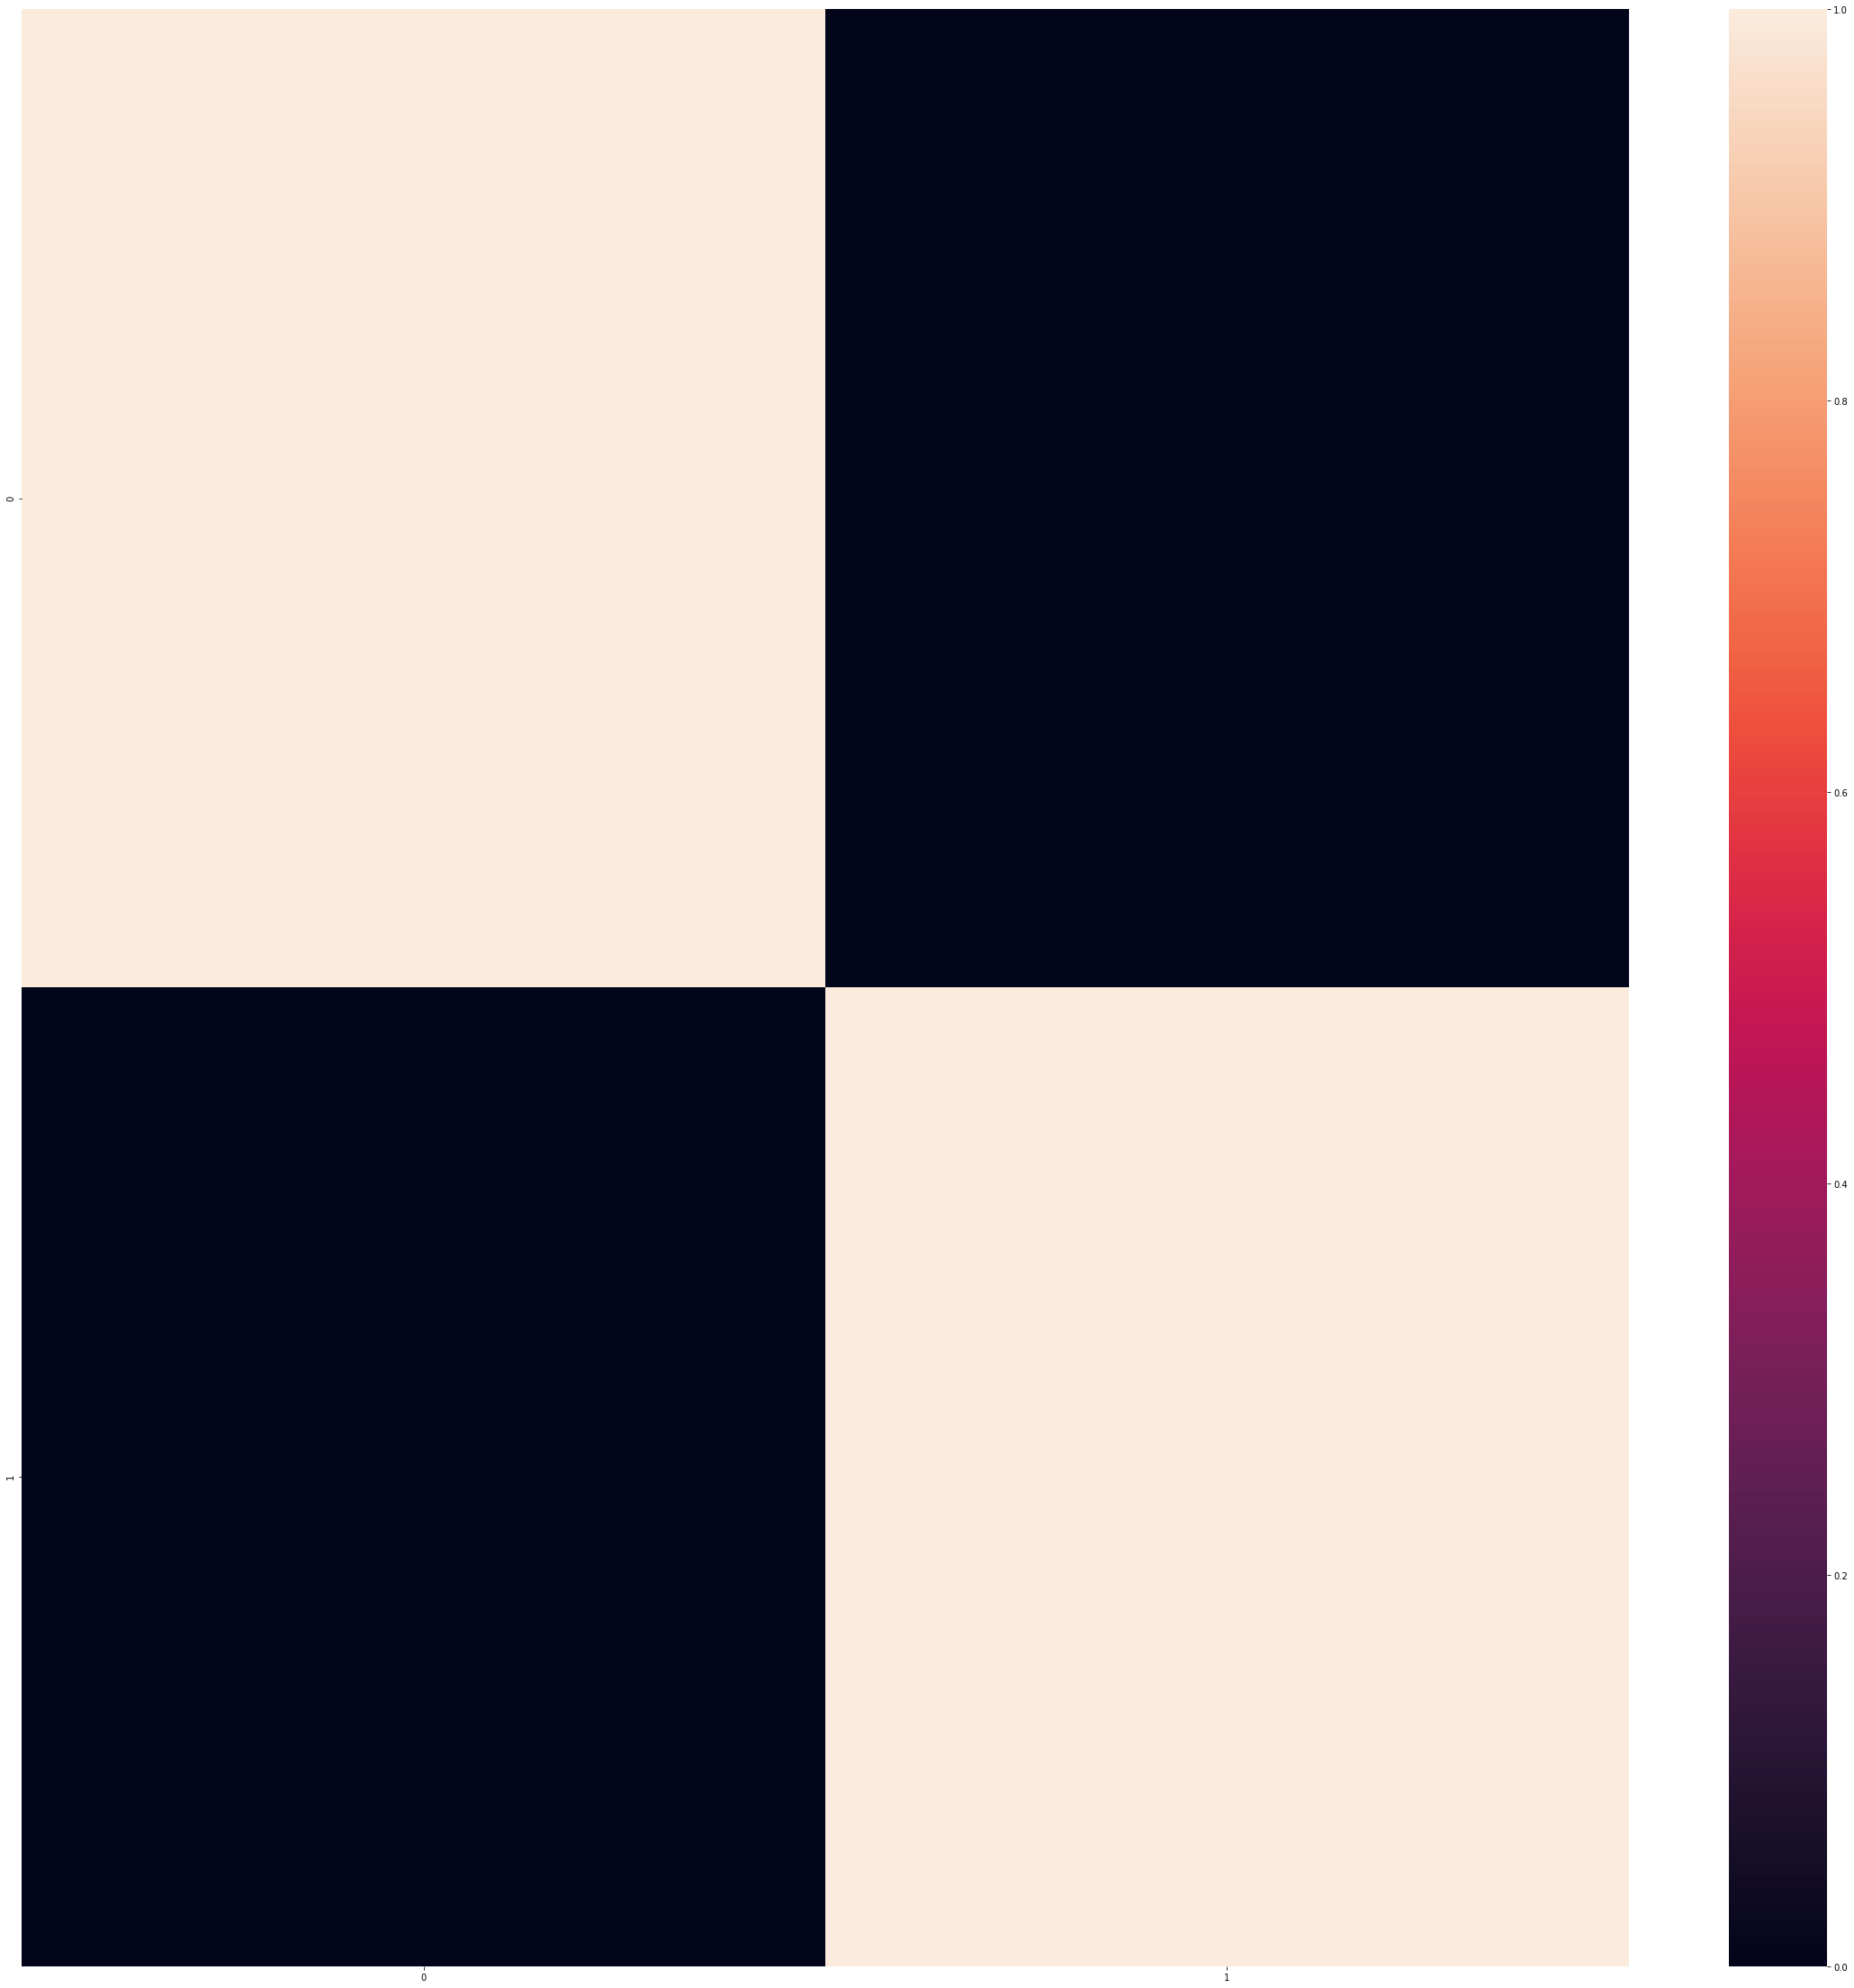

In [26]:
pca = PCA(n_components=2)
pca_transformed = pd.DataFrame(pca.fit_transform(X))
plt.figure(figsize=(40, 40))
sns.heatmap(abs(pca_transformed.corr()))
plt.show()

# 5.1 Save Changes

In [27]:
test = pd.read_csv("test.csv")

train, val, test = create_feats(train), create_feats(val), create_feats(test)

In [28]:
for col in train.columns:
    if col not in high_corr_columns.columns:
        train.drop(col, axis=1, inplace=True)
        val.drop(col, axis=1, inplace=True)
        test.drop(col, axis=1, inplace=True)

In [29]:
test.columns

Index(['blueWins', 'ratioFirstBlood', 'differenceFirstBlood', 'ratioKills',
       'differenceKills', 'ratioDeaths', 'differenceDeaths', 'ratioAssists',
       'differenceAssists', 'ratioEliteMonsters', 'differenceEliteMonsters',
       'ratioDragons', 'differenceDragons', 'ratioTotalGold',
       'differenceTotalGold', 'ratioAvgLevel', 'differenceAvgLevel',
       'ratioTotalExperience', 'differenceTotalExperience',
       'ratioTotalMinionsKilled', 'differenceTotalMinionsKilled',
       'differenceGoldDiff', 'differenceExperienceDiff', 'ratioCSPerMin',
       'differenceCSPerMin', 'ratioGoldPerMin', 'differenceGoldPerMin'],
      dtype='object')

In [30]:
train.to_csv("train_engineered.csv")
val.to_csv("val_engineered.csv")
test.to_csv("test_engineered.csv")